# Matching network
Matric-based few shot learning，意指混合similarity、distance這些固定準則加入network中估計output、而非直接學習類別本身。在這之中，Siamese network就是利用高維embedded特徵之間的相關性或距離來做分類，這樣就可以對不特定的、或沒見過的類別做分類。

在這之上，衍伸出了matching network，透過與各個類別feature map的attention來找出label的類別。具體作法是計算query input 特徵和現有各類別source特徵
的attention作為該類別label的權重，並以各類別label的加權和作為query出來的label
$\hat y=\sum_{i=1}^k attention(\hat x,x_i)*y_i$

若是在特徵空間上，跟query高維distance最近的d個example的attention值為1，而其餘的example attention值為0的話，則可以等效於"d"-nearest-neighbor method，所以這個matching network可等效於weighted KNN。
(另外若是attention機制為二維矩陣的話可等效於使用某個二維kernel的*kernel density estimator*)

原文中使用cosine similarity算attention，而這邊的x,y都是vector，x是input 特徵、y是one hot label。意思是以對examples特徵的attention為權重，對example對應的各label one hot vector做加權和。

**總之與後來居上的Relation net很類似Matching network的就是想使用神經網路做embedding，然後用這個embedded特徵做generalized的KNN**

## 範例內容
這次的資料集與Siames Network範例中的資料集一樣是使用[AT & T's the Database of Faces](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)做人臉辨識範例，40個人每人共有10張不同角度的照片。

在N-way-k-shot的Matching network中，需要N個class中每個class都要k張圖片做source，至少1張做query。

我們這次的任務是希望network學會只依照片來辨別人臉屬於哪個人：

選出5個不同人的照片各三張，並從這五個人的照片中再抽出一張，network必須辨識這一張屬於哪個人。

**程式碼部分會做以下部分：**
* Data Loader
* 資料抽樣、切分
* 建立模型
* 模型訓練
* 預測結果

# Data Loader
* (meta)batch: 一次訓練BATCH_SIZE個task
* task: 40人選5人不重複
* support: 5人資料中從每人10張選3張當support
* query: 5人資料中再各選1張當query(不重複選取)

In [ ]:
# Colab上的話要下載資料
# !gdown https://drive.google.com/u/1/uc?id=1sSAsIVQl4u_eMWw4t9dfD3gGnHKwAUhz&export=download
# !unzip orl_faces.zip
# !mkdir data
# !mv orl_faces/ data

In [1]:
'''Toolboxs'''
import cv2
import re
import time
import os
from os.path import join
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
'''Tensorflow'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Bidirectional, \
    BatchNormalization, ReLU, MaxPool2D,LSTM,Dropout
from tensorflow.keras import Model
from tensorflow.keras import backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
if len(gpus)>1:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{len(gpus)-1}"

先設定讀取圖片程式，這個資料集圖檔讀取方式需自訂，要輸入圖片的和寬、高、最大值，其中header是圖檔的標頭，讀取時要略過

圖片路徑為{orl_faces資料夾}/s1到s40

每個subject的圖片放在不同資料夾

In [2]:
W,H,CH = 64,64,1
'''pgm檔讀取程式'''
def read_pgm(filename):
    byteorder='>'
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
'''完整影像讀取程式，含pre-process'''
def load_img(path, width = W):
    img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2
    center_square = np.array([width,width])// 2
    new_size=(width,width)
    
    # cropping + resize
    img = img[oh:oh + shape_dst, ow:ow + shape_dst]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img)
SUFFIX='.pgm'

這次要做5 way 3 shot的data loader，且support中每個class都抽一個query

* support: BATCH_SIZE x (5 x 3) x 長 x 寬 x 顏色頻道(1)
* query: BATCH_SIZE x 5 x 長 x 寬 x 顏色頻道(1)

會先load in set中的的各種class排列組合 shuffle一次

再來每個meta batch依照batch size抽取數個排列組合

接著依照順序5人中每人抽3張丟進support的位置中，再每人抽一張丟進query的位置中
support set的label為被抽到的順序，依序是0,1,2,3,4
query set的label就照著support去配置，看抽到的是前面support中的第幾個人就是幾號，採one hot encoding

In [3]:
WAYS = 5
SHOTS=3
QUERIES=WAYS*1
BATCH_SIZE=8

首先列出sourse跟target有哪些classes

In [4]:
np.random.seed(2021)
tf.random.set_seed(2021)

# DATA_ROOT=join("..","..","data")
DATA_ROOT="I:\AIA Small Data\datasets"
all_classes = glob(join(DATA_ROOT,"orl_faces","*"))
source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

total 40 classes=source 32 + target 8 classes


篩掉圖片數不滿足的人

In [5]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

In [6]:
## exclude classes with too few examples
source_classes=[sdir for sdir in source_classes if len(glob(join(sdir,'*'+SUFFIX)))>SHOTS+QUERIES]

sorce_len=len(source_classes)
print(f"source {sorce_len} + target {target_len} classes")

source 32 + target 8 classes


In [7]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

建立每個人的loader，隨意從每個人的圖片中抽取 (尚未指定張數)

In [8]:
'''Mapping function for loading'''
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source set中每個人都有一個tf Dataset loader'''
source_sub = [
    tf.data.Dataset.list_files(join(sc,'*'+SUFFIX), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
'''Target set中每個人都有一個tf Dataset loader'''
target_sub = [
    tf.data.Dataset.list_files(join(sc,'*'+SUFFIX), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]

建立每個task的loader，隨意從WAY個人抽取SHOT張，並再隨機指派每個way的class是從0~WAY-1的哪一個

In [9]:
def tf_shuffle(x,y):
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    shuffled_x = tf.gather(x, shuffled_indices)
    shuffled_y = tf.gather(y, shuffled_indices)
    return shuffled_x,shuffled_y

In [10]:
def gen(all_sub):
#     order=np.random.permutation(len(all_sub))
#     for tasks in range(len(all_sub)//WAYS):
    '''先決定好順序'''
    order=np.random.permutation(len(all_sub))  
    '''For each task'''
    for tasks in range(len(all_sub)//WAYS):
        '''從已決定好的順序拉出WAY個人'''
        picked=[all_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        support = tf.concat(
            [
                next(
                    iter(
                        sub.batch(SHOTS).prefetch(SHOTS)
                    )
                    ) for sub in picked
            ]
            , axis=0)
        idxs=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
            [
                next(
                    iter(
                        picked[idx].batch(1).prefetch(1)
                    )
                    ) for idx in idxs
            ]
            , axis=0)
        '''Shuffle support for differnt order'''
        s_x,s_y=tf_shuffle(support,np.repeat(range(WAYS),SHOTS))    
        '''Concatenate'''
        x=tf.concat((s_x, query), axis=0)
        y=tf.concat((s_y,idxs), axis=0)
        
        yield x, keras.utils.to_categorical(y,num_classes=WAYS)

建立data generator，可以一次抽一個meta batch的資料
1. 要input一個function(這邊用partial產生一個預先設定好參數的function)
1. output types要對好前面的格式
2. output shape要給對

In [17]:
MLUT=16
data_source = tf.data.Dataset.from_generator(partial(gen,source_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(WAYS*SHOTS+QUERIES,WAYS))
                                            ).prefetch(BATCH_SIZE).repeat(MLUT).shuffle(buffer_size=999).cache().batch(BATCH_SIZE)
data_target = tf.data.Dataset.from_generator(partial(gen,target_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(WAYS*SHOTS+QUERIES,WAYS))
                                            ).repeat(MLUT*4).cache().batch(BATCH_SIZE)

可以看一下每次sample出來的東西
* X:共BATCH_SIZE個meta batch,有WAYS*SHOTS+QUERIES個圖，每個圖WxHxCH大小
* y:每個meta batch共WAYS*SHOTS+QUERIES個答案

In [12]:
for source_x,source_y in data_target:
    break

Support 0


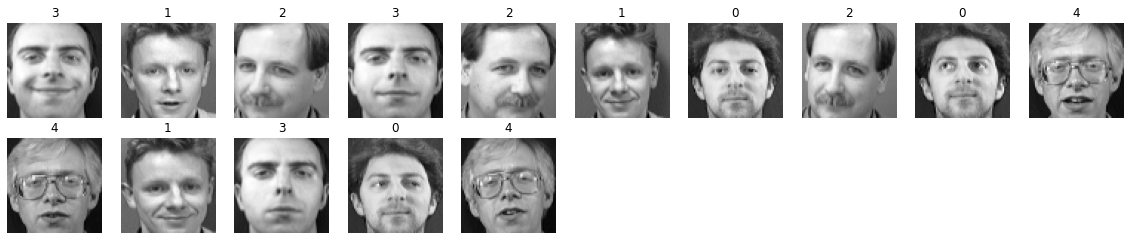

Query 0


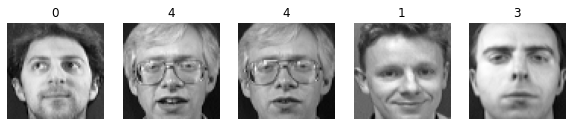

In [13]:
plt.figure(figsize=(20,6));ee=1
batch=0
print(f"Support 0")
for jj in range(WAYS*SHOTS):
    plt.subplot(SHOTS,WAYS*2,ee);plt.imshow(source_x[batch,jj,...,0],"gray")
    plt.title(f"{source_y[batch,jj].numpy().argmax(-1)}");plt.axis("off");ee+=1
plt.show()
print("Query 0");plt.figure(figsize=(10,2));ee=1
for jj in range(WAYS+SHOTS,WAYS+SHOTS+QUERIES):
    plt.subplot(1,QUERIES,ee);plt.imshow(source_x[batch,jj,...,0],"gray")
    plt.title(f"{source_y[batch,jj].numpy().argmax(-1)}");plt.axis("off");ee+=1
plt.show()

# 建立模型

大致長這樣：將各個support和query做embedding，且彼此embedding function會互相影享。接著query對各support做attention來當各個support label的weight，最後取softmax來做預測。

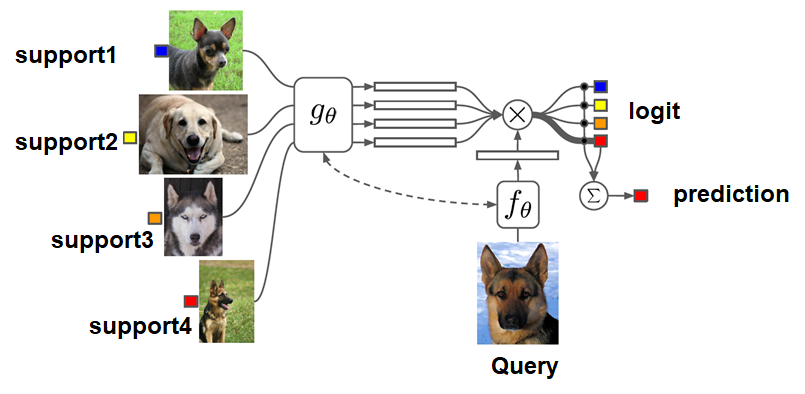


**細部需要拆解開來說明:**

首先使用CNN將input 投射到latent space，再把features都concatenate起來

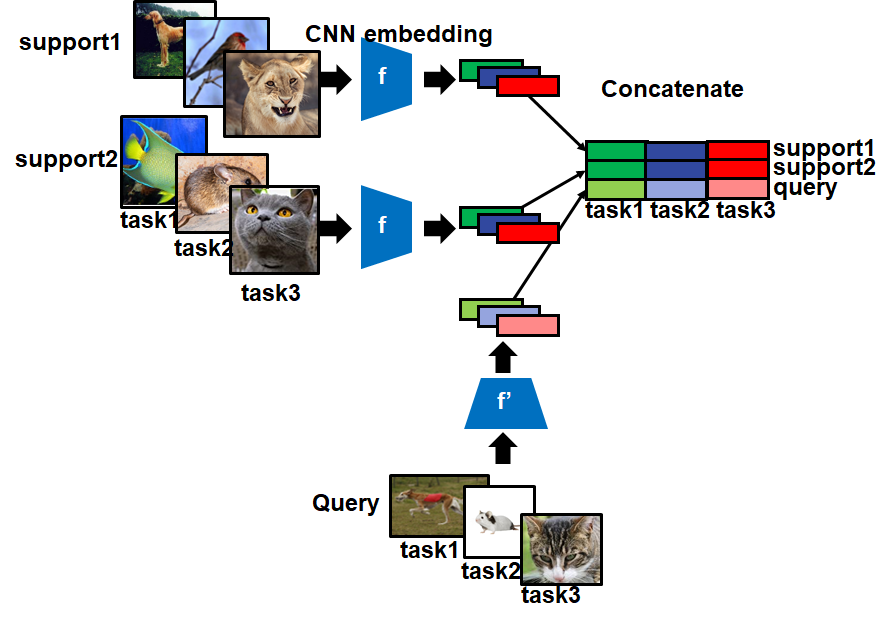

為了使model可以在source meta dataset學完後可以用在target meta dataset，能更加適應新的task，作者想辦法讓新的task中的support data也能改變model。於是作者不只採用CNN擷取example和qurey image的feature map，還額外使用含attention機制的bi-directional LSTM(attLSTM)將兩者做attention。例如若是在MiniImageNet資料集中，CNN的部分已經學會擷取自然以及生活圖像特徵，如果將這個model應用在醫學影像上，那除了CNN的圖像特徵擷取外，attLSTM還能額外到調適embedding的作用，這樣便能支援zero shot到few shot的adaptation。

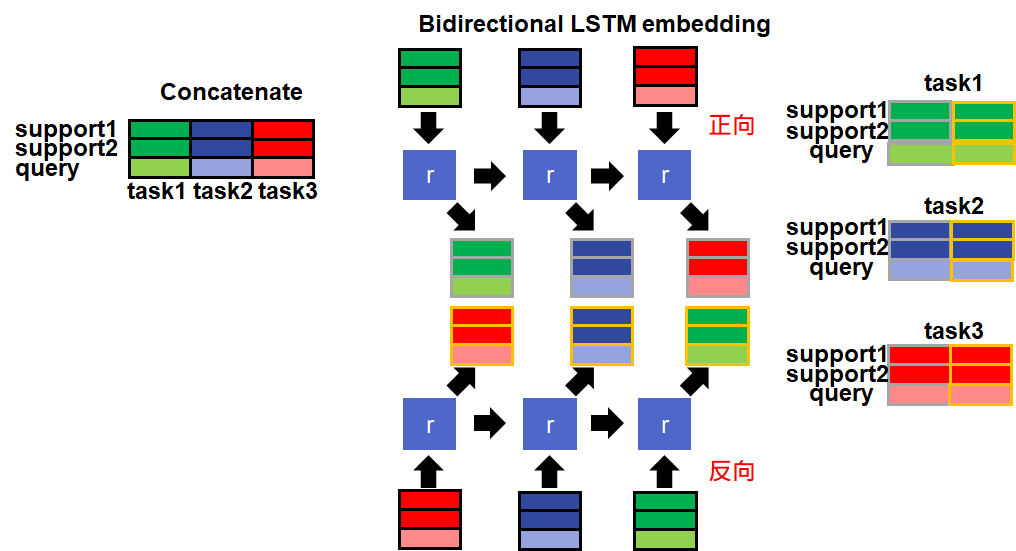

補充說明，論文雖然有提到因為LSTM作用在有序的資料上，所以資料進到model前最好進行排序(參考order matters 這篇論文)，但作者的github中的dataloader只有使用random permutation排序而已，也能達成好的adaptation效果，因為attention機制也起到一定作用。

接著，這個高維空間的distance可以用很多方式定義，原文提供最簡單的方式是*soft-max* of *cosine distance*，可以確保值域在0~1之間且可用來近似機率分佈。最後loss function

可以直接用categorical cross entropy來訓練。

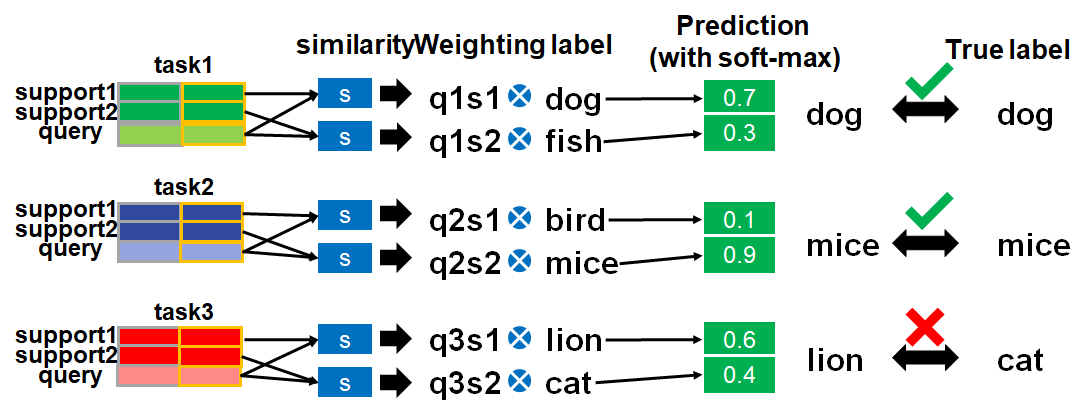

這邊使用model class來建立Matching network model

在def __init__中會宣告初始值:
- 其中除batch size,長,寬,channel數外最重要的就是CNN embedding model和bidirectional LSTM embedding model。

def call 中會宣告forwarding方式:
- 把batch中每個support都丟進CNN中、query也丟進CNN中個別抓出第一層特徵。
- 然後把meta batch當作time step依序丟進lstm裡面做第二層特徵(依作者說這樣換一個dataset也可以適應)
- 接著算query和source第二層特徵的similarity，依此作為去對source的label做attention，算值出來做softmax。

In [18]:
class MatchingNetwork(Model):
    def __init__(self, way, w, h, c, lstm_size=32):
        super(MatchingNetwork, self).__init__()

        self.way = way
        self.w, self.h, self.c = w, h, c
        # CNN network拿來做各個class examples的embedding
        self.g = tf.keras.Sequential([
            Conv2D(filters=64, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPool2D((2, 2)),
            Dropout(.25),

            Conv2D(filters=64, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPool2D((2, 2)),
            Dropout(.25),
            
            Conv2D(filters=64, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPool2D((2, 2)),
            Dropout(.25),
            
            Conv2D(filters=64, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPool2D((2, 2)),
            Dropout(.25),
            Flatten()]
        )
        # 拿來做包含不同class example的embedding，embedding function會受data domain影響
        assert self.w == self.h, "Current model operates only with square images for now"
        self.fce_dim = int(np.floor(self.w / 16))**2 * 64 # Input LSTM dimenstion
        self.fce = tf.keras.Sequential([
            Bidirectional(tf.keras.layers.LSTM(lstm_size, return_sequences=True)),
            Dropout(.25)
        ])
#     @tf.function
    def call(self, x_support, y_support, x_query, y_query):
        def _calc_cosine_distances(support, query_img):
            """
            Calculate cosine distances between support images and query one.
            Args:
                support (Tensor): Tensor of support images
                query_img (Tensor): query image
            Returns:
            """
            # 初始化
            eps = 1e-10
            similarities = tf.zeros([ self.support_samples,  self.batch],tf.float32)
            i_sample = 0
            '''每個support 影像都做比較'''
            # support:(5, 32, 64)
            # query_img:(32, 64)
            for support_image in support:
                # support_image:(32, 64)
                # 算support 沿著feature dimension (64) 做 root of sum of square
                sum_support = tf.reduce_sum(tf.square(support_image), axis=1)
                support_magnitude = tf.math.rsqrt(
                    tf.clip_by_value(sum_support, eps, float("inf")))
                # 把query_img(32,64),support_image(32,64)相乘
                dot_prod = K.batch_dot(
                    tf.expand_dims(query_img, 1),
                    tf.expand_dims(support_image, 2)
                )

                dot_prod = tf.squeeze(dot_prod)
                cos_sim = tf.multiply(dot_prod, support_magnitude)
                cos_sim = tf.reshape(cos_sim, [1, -1])
                similarities = tf.tensor_scatter_nd_update(similarities,
                                                           [[i_sample]],
                                                           cos_sim)
                i_sample += 1
            return tf.transpose(similarities)
    
        self.batch = x_support.shape[0]
        self.support_samples = x_support.shape[1]
        self.query_samples = x_query.shape[1]
        

        '''Embeddings for support images'''
        emb_imgs = []
        for i in range(self.support_samples):
            emb_imgs.append( self.g(x_support[:, i, :, :, :]) )

        # Embeddings for query images
        for i_query in range(self.query_samples):
            
            #tf.print("y_support shape:",y_support.shape)
            #         y_support shape: TensorShape([32, 5]) 首先support有25個，其中每五組是同一種圖，32個meta batch每個batch task都不一樣
            #tf.print("y_support_one_hot shape:",y_support_one_hot.shape)
            #         y_support_one_hot shape: TensorShape([32, 5, 5]) 化為1 hot後25個support都有一個1 hot 值
            #tf.print("y_query shape:",y_query.shape)
            #         y_query shape: TensorShape([32, 5]) query是從每個class各挑一個
            #tf.print("y_query_one_hot shape:",y_query_one_hot.shape)
            #         y_query_one_hot shape: TensorShape([32, 5, 5]) 化為1 hot後5個squery都有一個1 hot 值
            query_emb = self.g(x_query[:, i_query, :, :, :])
            emb_imgs.append(query_emb)
            '''將多了input的embedding stack起來'''
            outputs = tf.stack(emb_imgs)
            
            #tf.print("CNN embedded shape:",outputs.shape)
            #         CNN embedded shape: TensorShape([6, 32, 64]) 把support 和 1份 query塞進CNN後會有25+1個embedding for each meta batch，每個embedding 64維
            # Fully contextual embedding
            outputs = self.fce(outputs)
            #tf.print("fce embedded shape:",outputs.shape)
            #         fce embedded shape: TensorShape([6, 32, 64]) 以task這個維度做iteration(iter 32次)
            #                                                       每個字符都跑一圈BDLSTM，model原有32維但是bi-directional所以變成64維
            '''Cosine similarity between support set and query'''
            similarities = _calc_cosine_distances(outputs[:-1], outputs[-1])
            #tf.print("cosine_distances shape:",similarities.shape)
            #         cosine_distances shape: TensorShape([32, 25])
            '''Produce predictions for target probabilities'''
            similarities = tf.nn.softmax(similarities)
            #tf.print("similarity shape:",similarities.shape)
            #         similarity shape: TensorShape([32, 25])
            similarities = tf.expand_dims(similarities, 1)
            #tf.print("similarity shape expand:",similarities.shape)
            #         similarity shape expand: TensorShape([32, 1, 25])
            preds = tf.squeeze(K.batch_dot(similarities, y_support))
            #tf.print("preds shape:",preds.shape)
            #         preds shape: TensorShape([32, 5])
            query_labels = y_query[:, i_query, :]
            eq = tf.cast(tf.equal(
                tf.cast(tf.argmax(preds, axis=-1), tf.int32),
                tf.cast(tf.argmax(y_query[:, i_query,:], axis=-1), tf.int32)), tf.float32)
            
            if i_query == 0:
                ce = K.categorical_crossentropy(query_labels, preds)
                acc = tf.reduce_mean(eq)
            else:
                ce += K.categorical_crossentropy(query_labels, preds)
                acc += tf.reduce_mean(eq)

            emb_imgs.pop()
        return ce/self.query_samples, acc/self.query_samples

使用categorical cross entropy作為loss function，Adam optimizer來compile model

In [19]:
model=MatchingNetwork(way=WAYS, w=W, h=H, c=CH, lstm_size=32)
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

# 模型訓練
很不幸的在這個model有對batch這個rank和way這個rank做交換，無法使用model fit，要自己寫training function

這邊會將抽取數從200*5000次分解為200個epoch每個epoch 5000
訓練使用200 epoch、batch size為32個tasks，
在訓練時再使用validation split驗證loss是否下降，或者只是over fitting。

In [20]:

epochs=200


avg_loss,avg_acc=999,0

best_loss,patience=999,3
time_start = time.time()
sample=0
try:
    for epoch in range(epochs):
        #training phase
        # 使用tqdm顯示進度條
        session=tqdm(data_source)
        for source_x,source_y in session:
            sample+=1
            x_support=source_x[:,:WAYS*SHOTS,...]
            x_query=source_x[:,WAYS*SHOTS:WAYS*SHOTS+QUERIES,...]
            y_support=source_y[:,:WAYS*SHOTS,...]
            y_query=source_y[:,WAYS*SHOTS:WAYS*SHOTS+QUERIES,...]
            
            with tf.GradientTape() as tape:
                loss, acc =model(x_support,y_support,x_query,y_query)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            train_loss,train_acc=loss.numpy().mean(),acc.numpy().mean()
            # 使tqdm進度條每個meta batch都更新一次average loss,average acc
            session.set_postfix({"epoch":epoch,"sample":sample,"Training_loss": train_loss,"Training_acc":train_acc})
        all_loss,all_acc=[],[]
        for target_x,target_y in data_target:
            x_support=target_x[:,:WAYS*SHOTS,...]
            x_query=target_x[:,WAYS*SHOTS:WAYS*SHOTS+QUERIES,...]
            y_support=target_y[:,:WAYS*SHOTS,...]
            y_query=target_y[:,WAYS*SHOTS:WAYS*SHOTS+QUERIES,...]
            
            loss, acc =model(x_support,y_support,x_query,y_query)
            test_loss, test_acc=loss.numpy().mean(),acc.numpy().mean()
            all_loss.append(test_loss)
            all_acc.append(test_acc)
        test_loss, test_acc=   np.mean(all_loss),np.mean(all_acc)
        print(f"testing loss:{test_loss},testing acc:{test_acc}")
        if test_loss<best_loss:
            best_loss,patience=test_loss,3
            # Save CNN
            model.g.save('cnn_encoder.h5')
            # Save LSTM
            model.fce.save('lstm.h5')
        elif patience>0:
            patience-=1
        else:
            print("Out of patience")
            break
except KeyboardInterrupt:
    print("User interrupted")
time_end = time.time()

elapsed = time_end - time_start
hr, min = int(elapsed//3600), elapsed%3600//60
sec = elapsed-min*60
print(f"Training for {hr:0.4f}:{min:0.4f},{sec:0.4f}secs")

12it [01:13,  6.16s/it, epoch=0, sample=12, Training_loss=1.61, Training_acc=0.7]  


testing loss:1.6069399118423462,testing acc:0.671875


12it [00:04,  2.72it/s, epoch=1, sample=24, Training_loss=1.59, Training_acc=0.675]
0it [00:00, ?it/s]

testing loss:1.5891470909118652,testing acc:0.621874988079071


12it [00:04,  2.74it/s, epoch=2, sample=36, Training_loss=1.57, Training_acc=0.675]
0it [00:00, ?it/s]

testing loss:1.5713286399841309,testing acc:0.628125011920929


12it [00:04,  2.80it/s, epoch=3, sample=48, Training_loss=1.52, Training_acc=0.7]  
0it [00:00, ?it/s]

testing loss:1.522613763809204,testing acc:0.6656249761581421


12it [00:04,  2.84it/s, epoch=4, sample=60, Training_loss=1.39, Training_acc=0.775]
0it [00:00, ?it/s]

testing loss:1.3952655792236328,testing acc:0.746874988079071


12it [00:04,  2.79it/s, epoch=5, sample=72, Training_loss=1.16, Training_acc=0.75] 
0it [00:00, ?it/s]

testing loss:1.1627528667449951,testing acc:0.890625


12it [00:04,  2.79it/s, epoch=6, sample=84, Training_loss=0.975, Training_acc=0.8] 
0it [00:00, ?it/s]

testing loss:0.9964802265167236,testing acc:0.8656250238418579


12it [00:04,  2.82it/s, epoch=7, sample=96, Training_loss=0.826, Training_acc=0.9]  
0it [00:00, ?it/s]

testing loss:0.8658217191696167,testing acc:0.9000000357627869


12it [00:04,  2.85it/s, epoch=8, sample=108, Training_loss=0.717, Training_acc=0.925]
0it [00:00, ?it/s]

testing loss:0.7681398987770081,testing acc:0.9031250476837158


12it [00:04,  2.78it/s, epoch=9, sample=120, Training_loss=0.632, Training_acc=0.95]
0it [00:00, ?it/s]

testing loss:0.6858963966369629,testing acc:0.9156249761581421


12it [00:04,  2.83it/s, epoch=10, sample=132, Training_loss=0.573, Training_acc=0.95] 
0it [00:00, ?it/s]

testing loss:0.6374940276145935,testing acc:0.921875


12it [00:04,  2.80it/s, epoch=11, sample=144, Training_loss=0.519, Training_acc=0.95] 
0it [00:00, ?it/s]

testing loss:0.5972050428390503,testing acc:0.940625011920929


12it [00:04,  2.84it/s, epoch=12, sample=156, Training_loss=0.483, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.5629594922065735,testing acc:0.9500000476837158


12it [00:04,  2.85it/s, epoch=13, sample=168, Training_loss=0.442, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.5417108535766602,testing acc:0.949999988079071


12it [00:04,  2.79it/s, epoch=14, sample=180, Training_loss=0.418, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.5223325490951538,testing acc:0.9562499523162842


12it [00:04,  2.85it/s, epoch=15, sample=192, Training_loss=0.376, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.48084816336631775,testing acc:0.956250011920929


12it [00:04,  2.80it/s, epoch=16, sample=204, Training_loss=0.345, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.45546072721481323,testing acc:0.965624988079071


12it [00:04,  2.78it/s, epoch=17, sample=216, Training_loss=0.333, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.4718741774559021,testing acc:0.953125


12it [00:04,  2.81it/s, epoch=18, sample=228, Training_loss=0.316, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.4261664152145386,testing acc:0.96875


12it [00:04,  2.81it/s, epoch=19, sample=240, Training_loss=0.293, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.4383975863456726,testing acc:0.956250011920929


12it [00:04,  2.79it/s, epoch=20, sample=252, Training_loss=0.28, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.4082190990447998,testing acc:0.9656250476837158


12it [00:04,  2.84it/s, epoch=21, sample=264, Training_loss=0.269, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.41153156757354736,testing acc:0.9593750238418579


12it [00:04,  2.84it/s, epoch=22, sample=276, Training_loss=0.252, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.4126344919204712,testing acc:0.9593749642372131


12it [00:04,  2.79it/s, epoch=23, sample=288, Training_loss=0.245, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.38829857110977173,testing acc:0.965624988079071


12it [00:04,  2.80it/s, epoch=24, sample=300, Training_loss=0.226, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.3815397024154663,testing acc:0.9624999761581421


12it [00:04,  2.84it/s, epoch=25, sample=312, Training_loss=0.223, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.39160433411598206,testing acc:0.9624999761581421


12it [00:04,  2.80it/s, epoch=26, sample=324, Training_loss=0.198, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.3721764087677002,testing acc:0.9593750238418579


12it [00:04,  2.85it/s, epoch=27, sample=336, Training_loss=0.204, Training_acc=0.975]
0it [00:00, ?it/s]

testing loss:0.3656582832336426,testing acc:0.96875


12it [00:04,  2.79it/s, epoch=28, sample=348, Training_loss=0.184, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.36125683784484863,testing acc:0.9593750238418579


12it [00:04,  2.86it/s, epoch=29, sample=360, Training_loss=0.18, Training_acc=1]     
0it [00:00, ?it/s]

testing loss:0.34520870447158813,testing acc:0.971875011920929


12it [00:04,  2.79it/s, epoch=30, sample=372, Training_loss=0.174, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.3375202417373657,testing acc:0.96875


12it [00:04,  2.85it/s, epoch=31, sample=384, Training_loss=0.163, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.32947105169296265,testing acc:0.9750000238418579


12it [00:04,  2.76it/s, epoch=32, sample=396, Training_loss=0.163, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.3300716280937195,testing acc:0.9624999761581421


12it [00:04,  2.85it/s, epoch=33, sample=408, Training_loss=0.156, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.33337706327438354,testing acc:0.96875


12it [00:04,  2.78it/s, epoch=34, sample=420, Training_loss=0.166, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.3116864860057831,testing acc:0.96875


12it [00:04,  2.84it/s, epoch=35, sample=432, Training_loss=0.155, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.31623783707618713,testing acc:0.9906250238418579


12it [00:04,  2.79it/s, epoch=36, sample=444, Training_loss=0.162, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.3267446458339691,testing acc:0.9656250476837158


12it [00:04,  2.86it/s, epoch=37, sample=456, Training_loss=0.158, Training_acc=1]   
0it [00:00, ?it/s]

testing loss:0.316295325756073,testing acc:0.9656250476837158


12it [00:04,  2.79it/s, epoch=38, sample=468, Training_loss=0.152, Training_acc=1]   


testing loss:0.3122362494468689,testing acc:0.9781250357627869
Out of patience
Training for 0.0000:5.0000,28.6012secs


# Reference
[github](https://github.com/schatty/matching-networks-tf)

[paper](https://arxiv.org/abs/1606.04080)

[Order matters](https://arxiv.org/abs/1511.06391)

[kernel density estimator(KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation)

[soft-max](https://en.wikipedia.org/wiki/Softmax_function)

[cosine similarity/distance](http://sunnysaturdayafternoon.blogspot.com/2014/08/smilarity-euclidean-distance-cosine.html)

$attention(\hat x,x_i)=\frac{e^{cossim(\hat x,x_i)}}{\sum_{j=1}^k e^{cossim(\hat x,x_j)}}$

$cossim(\hat x,x_i)=\frac{\hat x \cdot x_i}{|\hat x||x_i|}$